                                               tweets  len  \
0   1246H, July 15, 2021. #CatbaloganCity Fire Sta...  140   
1                       Sana lahat nakapag-vaccine na   29   
2                      sana makapag pa vaccine na tom   30   
3   1/ I got my vaccine and one of the guys said '...   87   
4   Both my parents and I got vaccinated sa Antipo...  139   
..                                                ...  ...   
95  Ugh lain man gid effect ka vaccine basta may h...   54   
96  Sabe ko sa ate, “pic kita mam, pic mo din ako”...  138   
97  Ngayon ko lang to makikita. Maaga ako ntulog k...  140   
98  Kala ko wala kong mararamdaman sa vaccine omig...  100   
99  so makikipagsapalaran na naman ak hini na pagt...   57   

                  date  sentiment  
0  2021-07-15 12:39:13          0  
1  2021-07-15 12:33:21          0  
2  2021-07-15 12:29:48          0  
3  2021-07-15 12:25:59          0  
4  2021-07-15 12:18:12          0  
..                 ...        ...  
95 

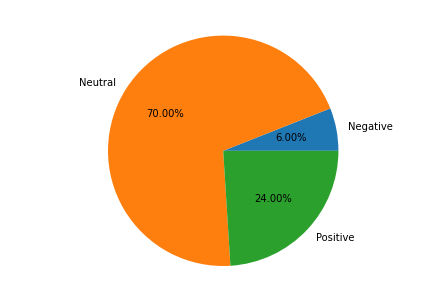

In [1]:
from tweepy import API
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

from textblob import TextBlob

import twitter_credentials
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

    def get_twitter_client_api(self):
        return self.twitter_client

class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))

        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1

    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        
        return df

if __name__ == "__main__":
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    query = "vaccination OR #vaccination OR vaccine OR pfizer OR sinovac OR moderna OR astrazeneca OR COVID19 OR COVID-19"

    places = api.geo_search(query="PHILIPPINES",granularity="country")
    place_id = places[0].id

    tweets = api.search(q=query + "AND place:%s" % place_id, count=100)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    print(df.head(100))
    
    a = np.array(df['sentiment'])
    unique, counts = np.unique(a, return_counts=True)

    sum = counts[0] + counts[1] + counts[2]
    
    status = ['Negative', 'Neutral', 'Positive']
    get_status = [counts[0]/sum, counts[1]/sum, counts[2]/sum]

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis('equal')
    ax.pie(get_status, labels=status, autopct='%1.2f%%')
    plt.show()